# test model on test data 
Test the model on the test data and save the results.


In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
sys.path.append("..")
from data import BreizhCrops
import torch
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times, plot_timestamps_left_per_class
from utils.doy import get_doys_dict_test, get_doy_stop
from utils.helpers_config import set_up_config, save_config
from utils.test.helpers_testing import get_test_stats_from_model
import matplotlib.pyplot as plt
from utils.plots_test import plot_confusion_matrix, plot_fig_class_prob_wrt_time_with_mus
from utils.test.load_model import get_all_runs, get_best_run, get_loaded_model_and_criterion, \
    get_model_and_model_path
from utils.helpers_mu import get_mus_from_config
from utils.metrics import get_std_score
import argparse

In [13]:
local_dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
print("Local dataroot: ", local_dataroot)

Local dataroot:  C:\Users\anyam\elects_data


## Download the model from wandb 

In [4]:
entity, project, sweep = "aurenore", "MasterThesis", "final_experience"
runs_df, runs = get_all_runs(entity, project)
df = runs_df[runs_df.sweep == sweep]

In [5]:
print(f"Number of runs in sweep {sweep}: ", len(df))
df.head()

Number of runs in sweep final_experience:  414


,summary,config,name,sweep,start_date
2,"{'harmonic_mean': 0.20265817411847617, 'elects...","{'mu': 150, 'mus': [150, 116, 110, 140, 150, 1...",neat-sweep-522,final_experience,2024-07-01T07:45:57
3,"{'alpha': 0.5, 'accuracy': 0.7513143669564445,...","{'mu': 150, 'mus': [146, 143, 103, 142, 150, 1...",laced-sweep-521,final_experience,2024-07-01T07:35:21
4,"{'lin_regr_zt_loss': 1.1751254796981812, 'clas...","{'mu': 150, 'mus': [92, 26, 25, 102, 150, 150,...",giddy-sweep-520,final_experience,2024-07-01T07:33:45
5,"{'alpha': 0.7, 'kappa': 0.7031309020197575, 'f...","{'mu': 150, 'mus': [104, 75, 25, 103, 150, 150...",hopeful-sweep-519,final_experience,2024-07-01T07:15:11
6,"{'fscore': 0.7145490346084742, 'boxplot': {'he...","{'mu': 150, 'mus': [173, 188, 115, 211, 150, 1...",ethereal-sweep-517,final_experience,2024-07-01T07:06:33


get the best run according to a metric 

In [7]:
metric = "harmonic_mean"
run = get_best_run(df, runs, metric)
print("configurations of the best run:")
print("-"*50)
for key, value in run.config.items():
    print(f"{key}: {value}")
print("-"*50)

chosen run:  v2
with harmonic_mean:  0.6739866772811042
configurations of the best run:
--------------------------------------------------
mu: 150
mus: [102, 56, 25, 102, 150, 142, 142]
loss: daily_reward_piecewise_lin_regr
alpha: 1
device: cuda
epochs: 100
factor: v2
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /home/amauron/elects/data/elects_data
p_thresh: 0.5
patience: 30
snapshot: /home/amauron/elects/data/elects_snapshots/model.pth
batchsize: 256
corrected: True
alpha_decay: [1, 0.5]
hidden_dims: 128
loss_weight: balanced
weight_decay: 0
backbonemodel: LSTM
class_weights: [0.04731182754039765, 0.02670983411371708, 0.14316703379154205, 0.01290007308125496, 1, 0.011567785404622557, 0.010797104798257353]
decision_head: day
learning_rate: 0.001
nb_parameters: 264994
sequencelength: 365
validation_set: valid
daily_timestamps: True
day_head_init_bias: None
percentage_alpha_1: 0.6462034
percentage_alpha_2: 0.10285531
percentage_alpha_3: 0.25094128
percentages_other_alphas: [

Get the model from the run name, which was trained on the same dataset as the og elects: 

In [14]:
run_name = "light-lake-5731"
run_idx = runs_df[runs_df.name == run_name].index[0]
run = runs[run_idx]
run_config = argparse.Namespace(**run.config)
model_artifact, model_path = get_model_and_model_path(run)

config_path = save_config(model_path, run)

print("config:")
for key, value in run.config.items():
    print(f"{key}: {value}")

wandb:   1 of 1 files downloaded.  


config file saved at:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-9exls4lc-model.pth-v3\config.json
config:
loss: daily_reward_piecewise_lin_regr
alpha: 1
device: cuda
epochs: 100
factor: v1
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /home/amauron/elects/data/elects_data
p_thresh: 0.7
patience: 30
snapshot: /home/amauron/elects/data/elects_snapshots/model.pth
batchsize: 128
corrected: False
criterion: daily_reward_piecewise_lin_regr
optimizer: AdamW
alpha_decay: [1, 0.4]
hidden_dims: 128
loss_weight: balanced
architecture: EarlyRNN
weight_decay: 0
backbonemodel: LSTM
class_weights: [0.0002943773870356381, 0.00015427677135448903, 0.000881723128259182, 8.686695946380496e-05, 1, 0.005409582518041134, 0.25, 0.00010121164814336224, 7.684454612899572e-05]
decision_head: day
learning_rate: 0.001
nb_parameters: 265252
sequencelength: 70
validation_set: valid
daily_timestamps: False
day_head_init_bias: 1
percentage_alpha_1: 0.00878819

## Test the model on the test set 
Set the sequence length to 150 like in the original paper. 

In [7]:
args = set_up_config(run_config)
args.dataroot = local_dataroot

In [8]:
# ----------------------------- LOAD DATASET -----------------------------
sequencelength_test = 150 # by elects paper
if args.dataset == "breizhcrops":
    dataroot = os.path.join(args.dataroot,"breizhcrops")
    input_dim = 13
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    test_ds = BreizhCrops(root=dataroot, partition="eval", sequencelength=sequencelength_test, corrected=args.corrected, \
        daily_timestamps=args.daily_timestamps, original_time_serie_lengths=args.original_time_serie_lengths, return_id=True)
    nclasses = test_ds.nclasses
    class_names = test_ds.labels_names
    print("class names:", class_names)
else:
    raise ValueError(f"dataset {args.dataset} not recognized")


2493572704 2493572704


loading data into RAM: 100%|██████████| 2463/2463 [00:01<00:00, 1657.04it/s]


1555075632 1555075632


loading data into RAM: 100%|██████████| 36915/36915 [00:21<00:00, 1711.43it/s]

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'orchards' 'permanent meadows'
 'temporary meadows']


In [9]:
# print all the attributes of test_ds
print("Attributes of test_ds:")
for attr in dir(test_ds):
    if not attr.startswith("__"):
        print(attr, ":", getattr(test_ds, attr))

Attributes of test_ds:
_is_protocol : False
class_weights : None
corrected : True
daily_timestamps : True
ds : <torch.utils.data.dataset.ConcatDataset object at 0x000001FB6808B990>
ds_1 : <data.breizhcrops.BzhBreizhCrops object at 0x000001FB5F149B50>
ds_2 : <data.breizhcrops.BzhBreizhCrops object at 0x000001FB6808BE90>
get_class_weights : <bound method BreizhCrops.get_class_weights of <data.breizhcrops.BreizhCrops object at 0x000001FB67DBCB90>>
get_sequence_lengths : <bound method BreizhCrops.get_sequence_lengths of <data.breizhcrops.BreizhCrops object at 0x000001FB67DBCB90>>
labels_names : ['barley' 'wheat' 'rapeseed' 'corn' 'orchards' 'permanent meadows'
 'temporary meadows']
nclasses : 7
return_id : True
sequencelength : 365


Extracting labels from dataset Test.


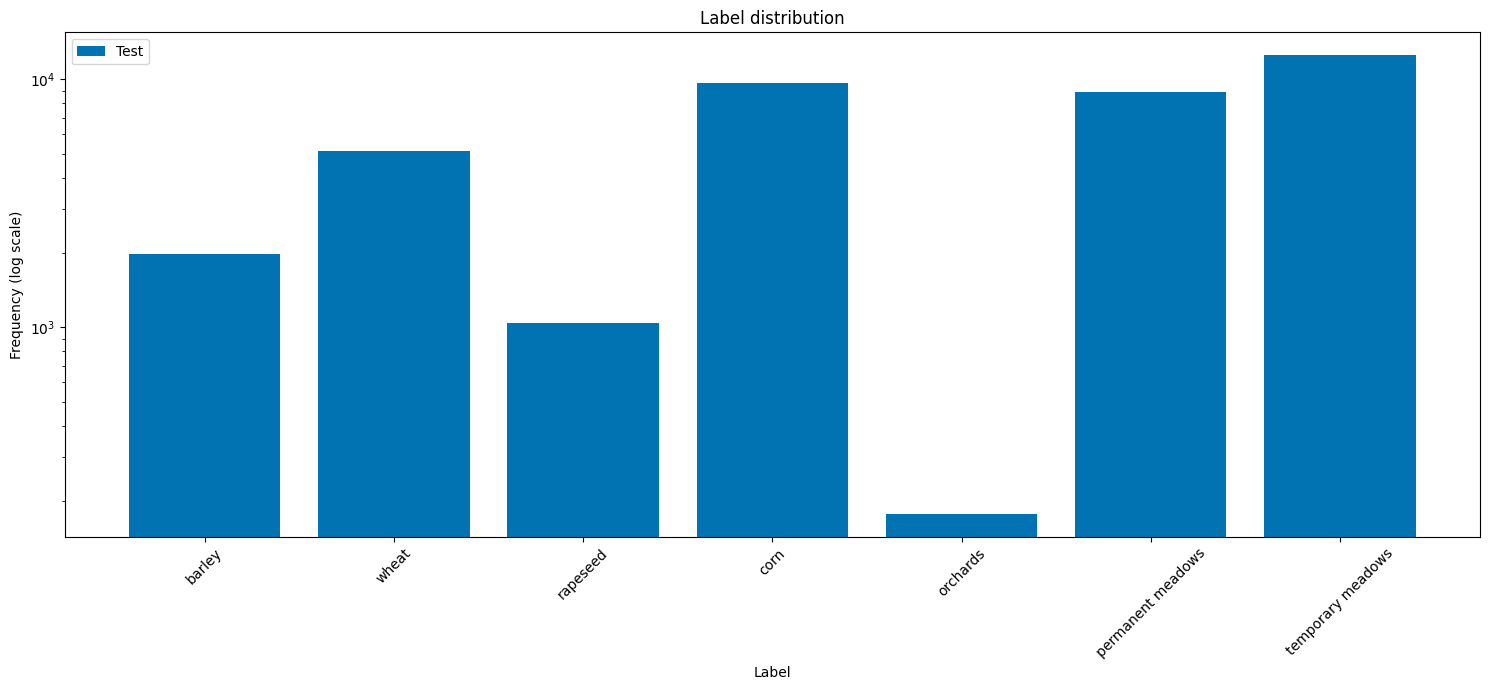

In [10]:
# take about 1 minute
# ----------------------------- VISUALIZATION: label distribution -----------------------------
datasets = [test_ds]
sets_labels = ["Test"]
fig, ax = plt.subplots(figsize=(15, 7))
fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

## Load the models and the criterions

In [11]:
mus = get_mus_from_config(run_config)
print("mus:", mus)

mus: tensor([13, 14,  9, 28, 28, 28, 28, 28, 28])


In [12]:
model, criterion = get_loaded_model_and_criterion(run, nclasses, input_dim, mus=mus)

wandb:   1 of 1 files downloaded.  
c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\..\utils\test\load_model.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(run_config.class_weights)


loss daily_reward_lin_regr selected, mus set to tensor([13, 14,  9, 28, 28, 28, 28, 28, 28])
model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-38p1gae4-model.pth-v10
The model has 67,108 trainable parameters.


## Test the model on the test dataset

In [13]:
test_stats, stats = get_test_stats_from_model(model, test_ds, criterion, run_config)

Since LSTM is used, extra padding is set to [0]
weights moved to device cuda


In [14]:
test_stats

{'test_loss': 0.32228723,
 'accuracy': 0.42015593651622163,
 'precision': 0.444729956448962,
 'recall': 0.46979035401518665,
 'fscore': 0.380381580313623,
 'kappa': 0.3458752348109787,
 'elects_earliness': 0.685616201474026,
 'classification_loss': 0.043713644,
 'earliness_reward': 0.006174798,
 'harmonic_mean': 0.5210218404391638}

## Graphs

fig saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-38p1gae4-model.pth-v10\boxplot_stopping_times.png


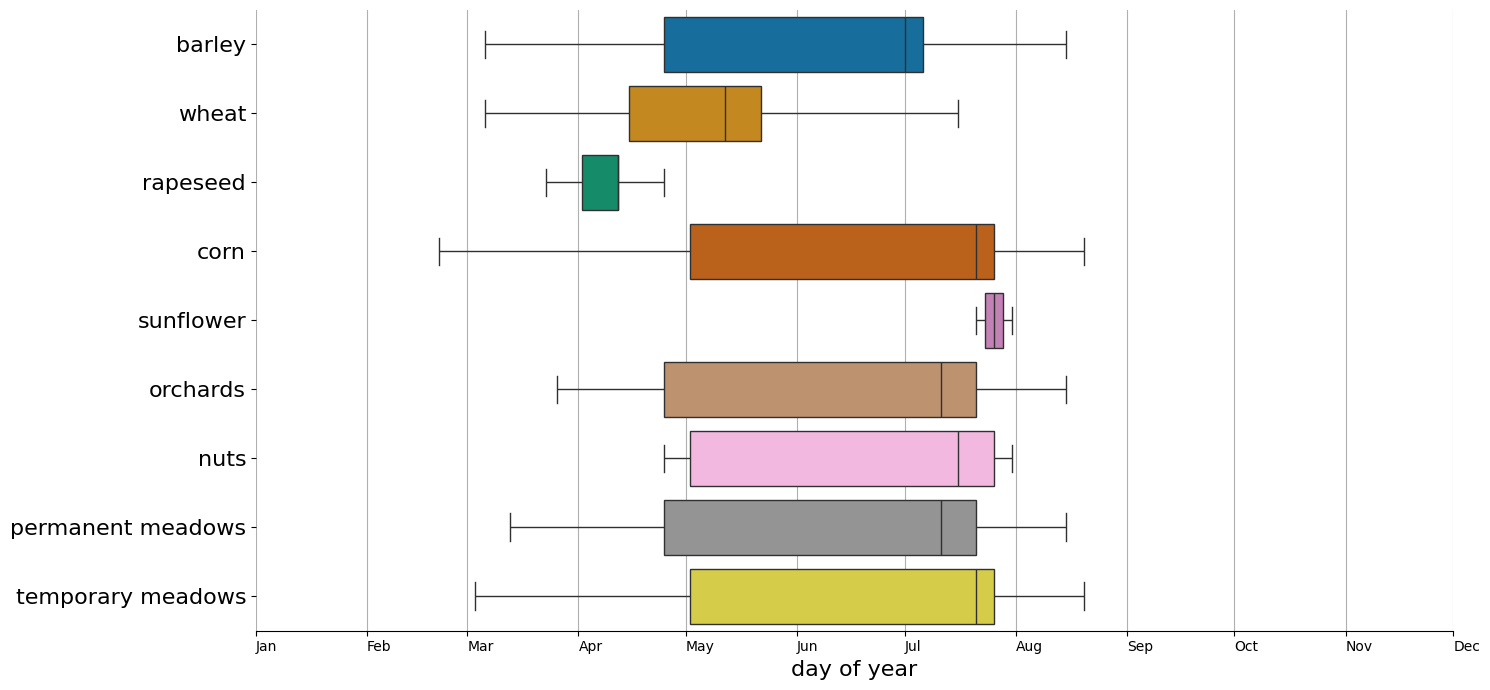

In [26]:

# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
if args.daily_timestamps:
    doys_stop = stats["t_stop"].squeeze()
else: 
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)
                
fig_boxplot.savefig(os.path.join(model_path, "boxplot_stopping_times.png"))
print("fig saved at ", os.path.join(model_path, "boxplot_stopping_times.png"))

fig saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-38p1gae4-model.pth-v10\confusion_matrix.png


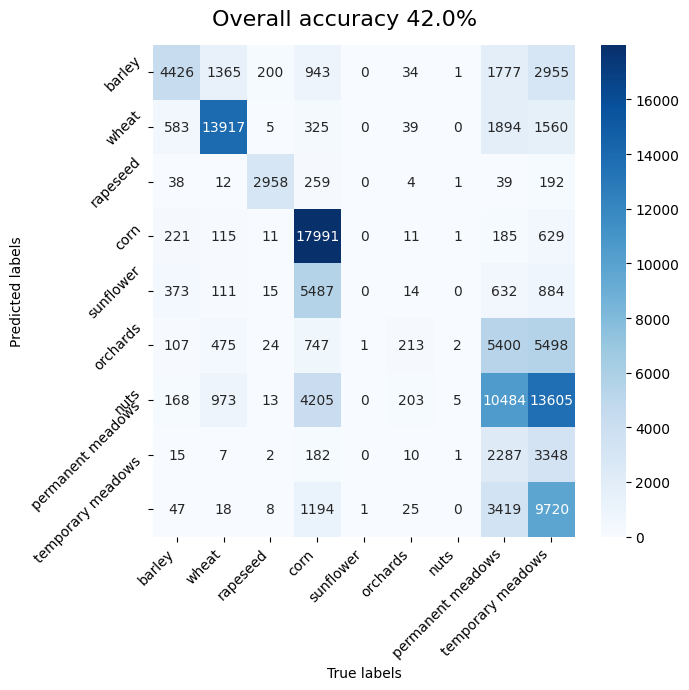

In [27]:
fig, ax = plt.subplots(figsize=(7,7))
fig = plot_confusion_matrix(stats["targets"][:, 0], stats["predictions_at_t_stop"].flatten(), class_names, fig, ax)
fig.savefig(os.path.join(model_path, "confusion_matrix.png"))
print("fig saved at ", os.path.join(model_path, "confusion_matrix.png"))

fig saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-38p1gae4-model.pth-v10\timestamps_left_per_class.png
fig saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-38p1gae4-model.pth-v10\class_probabilities_wrt_time.png


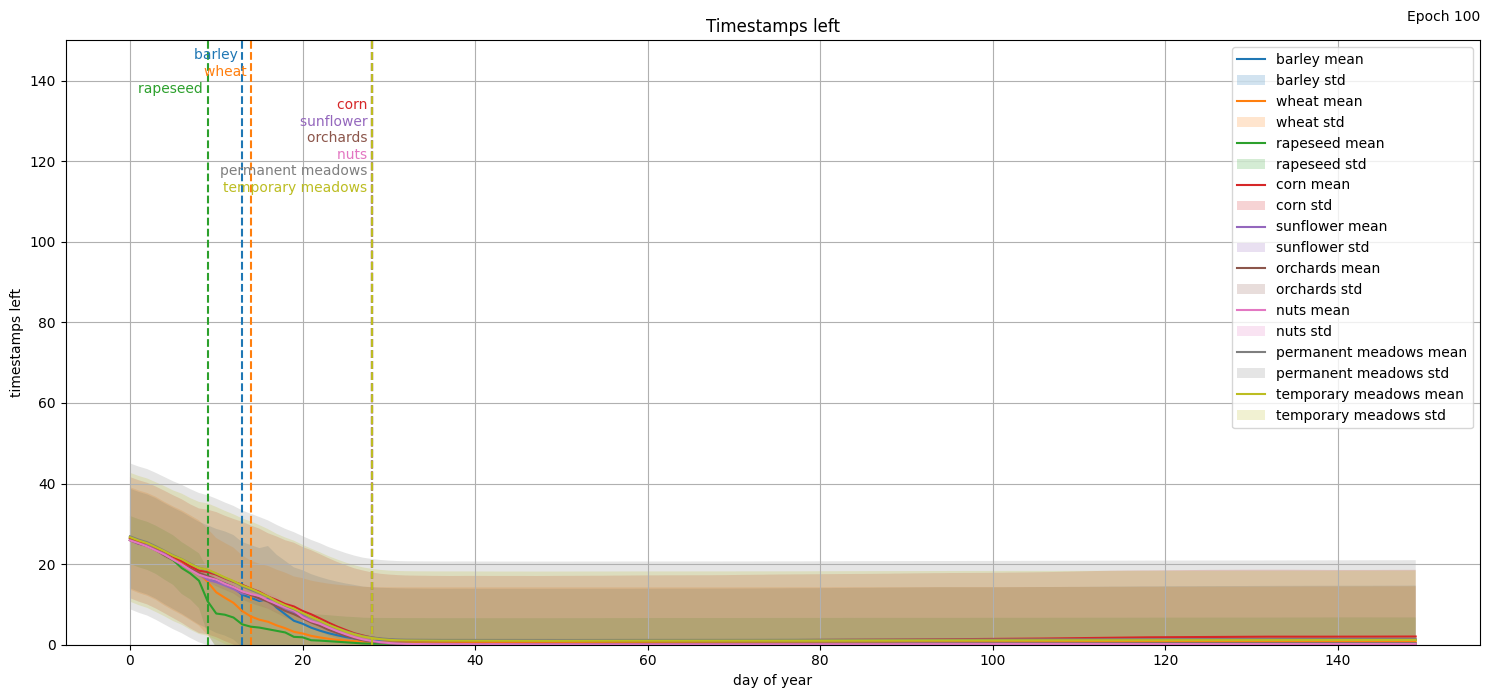

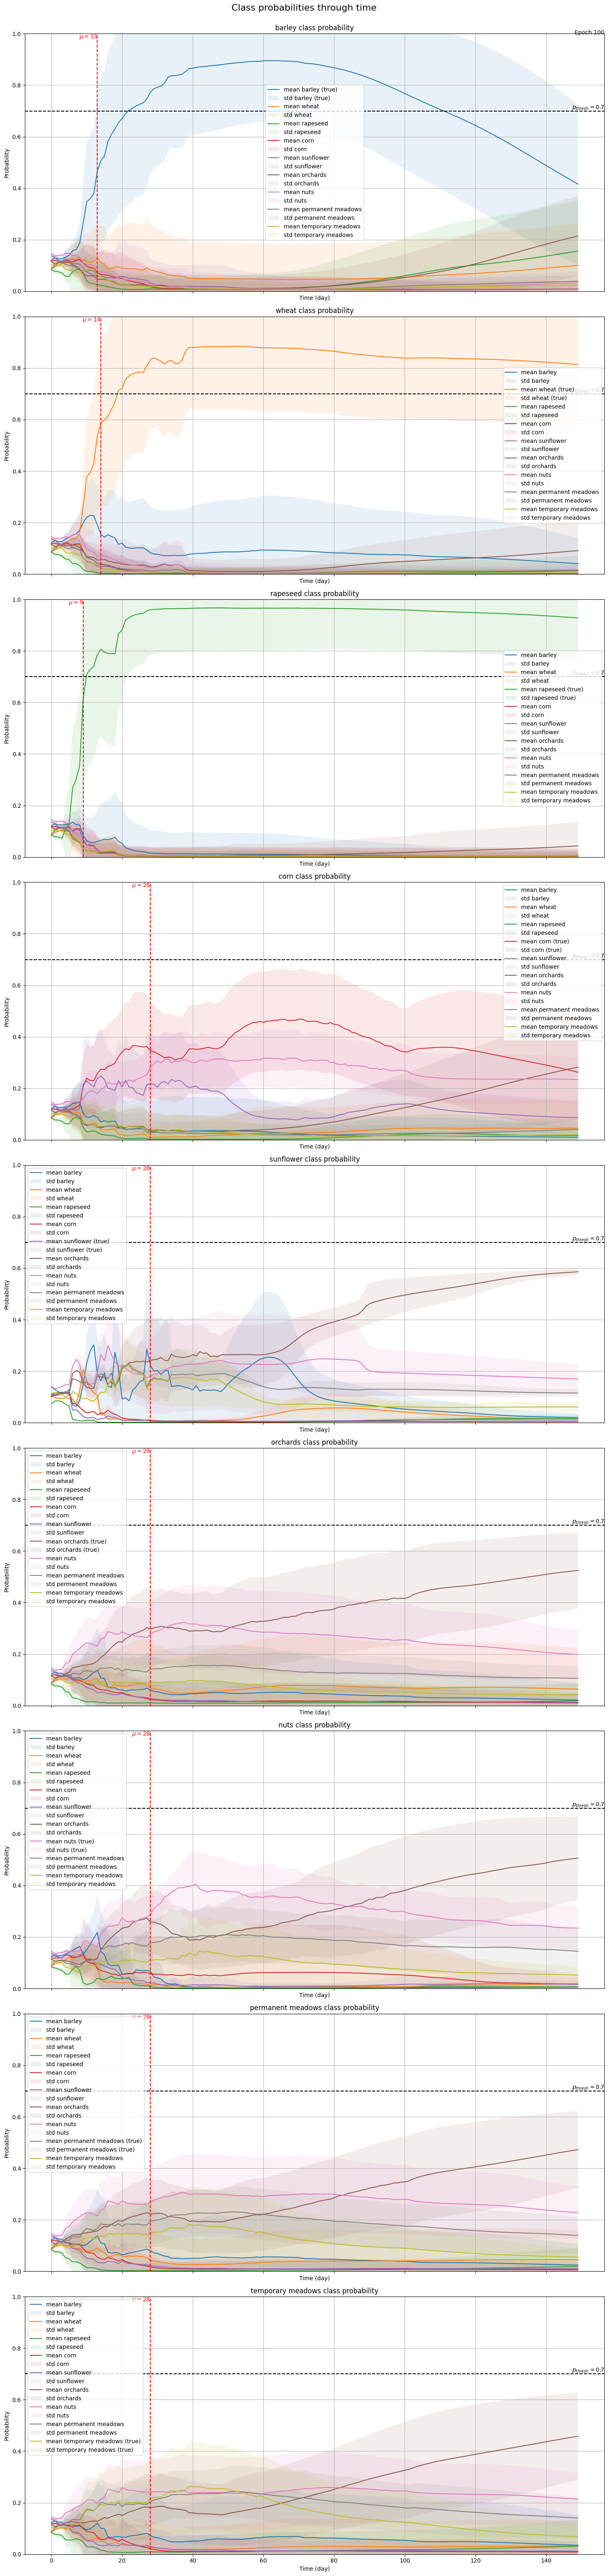

In [30]:
if run_config.loss == "daily_reward_lin_regr":
    fig_timestamps, ax_timestamps = plt.subplots(figsize=(15, 7))
    fig_timestamps, _ = plot_timestamps_left_per_class(fig_timestamps, ax_timestamps, stats, nclasses, class_names, mus, ylim=sequencelength_test, epoch=run_config.epochs)
    fig_timestamps.savefig(os.path.join(model_path, "timestamps_left_per_class.png"))
    print("fig saved at ", os.path.join(model_path, "timestamps_left_per_class.png"))
        
    fig_prob_class, axes_prob_class = plt.subplots(figsize=(15, 7*len(class_names)), nrows=len(class_names), sharex=True)
    fig_prob_class, _ = plot_fig_class_prob_wrt_time_with_mus(fig_prob_class, axes_prob_class, \
            stats["class_probabilities"], stats["targets"][:, 0], class_names, mus, run_config.p_thresh, \
            alpha=0.1, epoch=run_config.epochs)   
    fig_prob_class.savefig(os.path.join(model_path, "class_probabilities_wrt_time.png"))
    print("fig saved at ", os.path.join(model_path, "class_probabilities_wrt_time.png"))
     


# Metrics: Standard Deviation Score

In [17]:
std_score = get_std_score(stats, nclasses) 
print("std_score:", std_score)

std_score: 4.38399739786065
